**Question 1 – Programming (80 points):**
In this programming problem, you will get familiar with building a neural network using
backpropagation. You will write a program that learns how to recognize the handwritten digits using
stochastic gradient descent and the MNIST training data.
The MNIST database (Modified National Institute of Standards and Technology database is a large
database of handwritten digits that is commonly used for training various image processing systems



**Step 1 Data Acquisition and Visualization (10 pts):**


In this step, you need to:
(a) Download the “MNIST” dataset and extract the files. You will get four files with extension .gz

(e.g., train-images-idx3-ubyte.gz). You can use the provided function read_idx below to read in
the dataset. As its official description, the dataset is split into 60000 training images and 10000
images. The four file corresponds to the training images, training labels, testing images and
testing labels. You need to print out their shape to finish this step. (5 pts)

In [82]:
import gzip
import struct
import numpy as np

def read_idx(filename):
    with gzip.open(filename, 'rb') as f:
        zero, data_type, dims = struct.unpack('>HBB', f.read(4))
        shape = tuple(struct.unpack('>I', f.read(4))[0] for d in range(dims))
        return np.frombuffer(f.read(), dtype=np.uint8).reshape(shape)


In [83]:

# File paths for the dataset
train_images_path = 'data/train-images-idx3-ubyte.gz'
train_labels_path = 'data/train-labels-idx1-ubyte.gz'
test_images_path = 'data/t10k-images-idx3-ubyte.gz'
test_labels_path = 'data/t10k-labels-idx1-ubyte.gz'

# Read the dataset files
train_images = read_idx(train_images_path)
train_labels = read_idx(train_labels_path)
test_images = read_idx(test_images_path)
test_labels = read_idx(test_labels_path)

# Reshape and print the shapes of the datasets
print("Training Images Shape:", train_images.shape)
print("Training Labels Shape:", train_labels.shape)
print("Test Images Shape:", test_images.shape)
print("Test Labels Shape:", test_labels.shape)


Training Images Shape: (60000, 28, 28)
Training Labels Shape: (60000,)
Test Images Shape: (10000, 28, 28)
Test Labels Shape: (10000,)


B) To further understand what the dataset is, you need to use the ‘matplotlib’ library to print out a 
random data with code plt.imshow together with its label.(5 pts) You will see something like 
this:

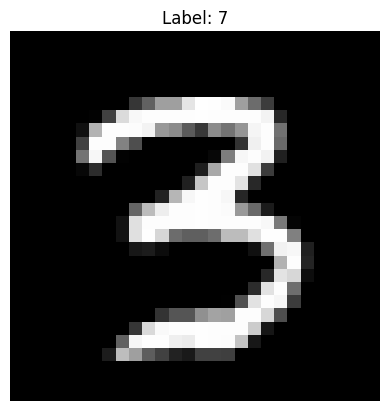

In [84]:
import matplotlib.pyplot as plt
import random

# Get a random index to select a random image and its label
random_index = random.randint(0, len(train_images))

# Select the image and its label
random_image = train_images[random_index]
random_label = train_labels[random_index]

# Visualize a random image and its label
random_index = random.randint(0, len(train_images))
random_image = train_images[random_index].reshape(28, 28)

# Plot the image using plt.imshow
plt.imshow(random_image, cmap='gray')
plt.title(f'Label: {random_label}')
plt.axis('off')  # Turn off axis
plt.show()


**Step 2 Data Preprocessing (10 pts):**

In this step, you need to: 

(a)  Normalize the pixel values of images to be between 0 and 1. (5 pts) 


In [85]:
# Normalize the pixel values of the images to be between 0 and 1
train_images_normalized = train_images / 255.0
test_images_normalized = test_images / 255.0

# Flatten the images
train_images_flattened = train_images_normalized.reshape(-1, 28 * 28)
test_images_flattened = test_images_normalized.reshape(-1, 28 * 28)



(b)  Convert the labels from categorical data into numerical values using one-hot encoding. (5 pts) 

hint: you can explore the eye function in Numpy.

In [86]:
# Convert labels to one-hot encoding
def one_hot_encode(labels, num_classes):
    num_labels = len(labels)
    index_offset = np.arange(num_labels) * num_classes
    one_hot_encoded = np.zeros((num_labels, num_classes))
    one_hot_encoded.flat[index_offset + labels.ravel()] = 1
    return one_hot_encoded


In [102]:
# Convert labels to one-hot encoding
num_classes = 10
train_labels_one_hot = one_hot_encode(train_labels, num_classes) #np.eye(num_classes)[train_labels]
test_labels_one_hot = one_hot_encode(test_labels, num_classes) #np.eye(num_classes)[test_labels]


**Step 3 Network Initialization (10 pts):**

We will work with a neuron network with two hidden layers, using Sigmoid function as the activation functions for hidden 
layers and softmax activation function for the output layer. To finish this, you need to:
 
(a)  Identify the auxiliary input including the Sigmoid function and its derivative and Softmax 


In [88]:
def sigmoid(x):
    clipped_x = np.clip(x, -500, 500)
    return 1 / (1 + np.exp(-clipped_x))

def sigmoid_derivative(x):
    return sigmoid(x) * (1 - sigmoid(x))

def softmax(x):
    e_x = np.exp(x - np.max(x, axis=-1, keepdims=True))  # for numerical stability
    return e_x / e_x.sum(axis=-1, keepdims=True)


In [89]:
np.random.seed(695)  # Setting the seed for reproducibility

input_size = 784
hidden_size1 = 128
hidden_size2 = 64
output_size = 10


# Initialize weights and biases for the neural network
weights_input_hidden1 = np.random.uniform(-0.1, 0.1, size=(input_size, hidden_size1))
biases_hidden1 = np.zeros(hidden_size1)

weights_hidden1_hidden2 = np.random.uniform(-0.1, 0.1, size=(hidden_size1, hidden_size2))
biases_hidden2 = np.zeros(hidden_size2)

weights_hidden2_output = np.random.uniform(-0.1, 0.1, size=(hidden_size2, output_size))
biases_output = np.zeros(output_size)




**Step 4 Feed Forward (10 pts): In this step, you need to:**

(a)  Define a function named feed_forward. Given an input x, it should output the sigmoid of wx+b 
where w and b indicates the weights and bias defined in step 2. (5 pts)

In [90]:
def feed_forward(x):
    # Flatten the input images
    x_flattened = x.reshape(-1, 28 * 28)

    hidden1_input = np.dot(x, weights_input_hidden1) + biases_hidden1
    hidden1_output = sigmoid(hidden1_input)

    hidden2_input = np.dot(hidden1_output, weights_hidden1_hidden2) + biases_hidden2
    hidden2_output = sigmoid(hidden2_input)

    output_layer_input = np.dot(hidden2_output, weights_hidden2_output) + biases_output
    output = softmax(output_layer_input)

    return hidden1_output, hidden2_output, output


**Step 5 Back Propagation (15 pts): In this step, you need to implement the back 
propagation:**


(a)  You need to compute the loss for the output layer first. Here, we use categorical cross entropy 
loss function given below for multi-class classification problem. (5 pts) Note, to achieve this, you 
need to first encode the categorical labels as numerical values using one-hot encoding finished 
in step 2. (5 pts)


In [91]:
def categorical_crossentropy(y_true, y_pred):
    n_samples = y_true.shape[0]
    y_pred_clipped = np.clip(y_pred, 1e-12, 1 - 1e-12)
    return -np.sum(y_true * np.log(y_pred_clipped)) / n_samples


(b)  Calculate the gradients for the weights and bias for each layer. Use the chain rule to compute 
gradients for previous layers. (10 pts)

In [92]:
def compute_gradients(x, hidden1_output, hidden2_output, output, y_true):
    # Flatten the input
    x_flattened = x.reshape(-1, 28 * 28)
    # Calculations for the output layer gradients
    
    grad_output = output - y_true
    weights_gradients_hidden2_output = np.dot(hidden2_output.T, grad_output)
    biases_gradients_output = np.sum(grad_output, axis=0)

    # Calculations for hidden layer 2 gradients
    grad_hidden2 = np.dot(grad_output, weights_hidden2_output.T) * sigmoid_derivative(hidden2_output)
    weights_gradients_hidden1_hidden2 = np.dot(hidden1_output.T, grad_hidden2)
    biases_gradients_hidden2 = np.sum(grad_hidden2, axis=0)

    # Calculations for hidden layer 1 gradients
    grad_hidden1 = np.dot(grad_hidden2, weights_hidden1_hidden2.T) * sigmoid_derivative(hidden1_output)
    weights_gradients_input_hidden1 = np.dot(x_flattened.T, grad_hidden1)
    biases_gradients_hidden1 = np.sum(grad_hidden1, axis=0)

    return weights_gradients_hidden2_output, biases_gradients_output, weights_gradients_hidden1_hidden2, biases_gradients_hidden2, weights_gradients_input_hidden1, biases_gradients_hidden1


**Step 6 Model Training (15 pts):**

In this step, you need to:

(a)  Use mini-batch gradient descent to update the parameters including weights and bias. Notice 
that a complete training round consists of a feed forward process, back propagation and 
parameter update. Define the batch size = 128 and epoch = 100. 

In [93]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
def compute_loss(predictions, targets):
    # Ensure numerical stability by clipping the predicted probabilities
    epsilon = 1e-15
    predictions = np.clip(predictions, epsilon, 1 - epsilon)

    # Calculate the categorical cross-entropy loss
    loss = -np.sum(targets * np.log(predictions)) / len(predictions)

    return loss


In [96]:
batch_size = 128
epochs = 100
learning_rate = 0.01
training_loss = []
roc_values = []

# Training loop
for epoch in range(epochs):
    total_loss = 0
    for i in range(0, len(train_images), batch_size):
        batch_images = train_images[i:i + batch_size]
        batch_labels = train_labels_one_hot[i:i + batch_size]

        # Handle the last incomplete batch
        if len(batch_images) < batch_size:
            # Adjust the gradient calculations for the last batch
            diff = batch_size - len(batch_images)
            remaining_images = train_images[:diff]
            remaining_labels = train_labels_one_hot[:diff]

            # Concatenate the remaining images and labels to the current batch
            batch_images = np.concatenate((batch_images, remaining_images))
            batch_labels = np.concatenate((batch_labels, remaining_labels))

        batch_images_flattened = batch_images.reshape(-1, 28 * 28)  # Flatten each image to a 1D array
        hidden1_output, hidden2_output, output = feed_forward(batch_images_flattened)
        gradients = compute_gradients(batch_images_flattened, hidden1_output, hidden2_output, output, batch_labels)

        # Update weights and biases using gradients
        weights_hidden2_output -= learning_rate * gradients[0]
        biases_output -= learning_rate * gradients[1]
        weights_hidden1_hidden2 -= learning_rate * gradients[2]
        biases_hidden2 -= learning_rate * gradients[3]
        weights_input_hidden1 -= learning_rate * gradients[4]
        biases_hidden1 -= learning_rate * gradients[5]

        # Calculate and print the loss
        loss = compute_loss(output, batch_labels)
        total_loss += loss

    # Append the average loss for the epoch to the training_loss list
    average_loss = total_loss / (len(train_images) / batch_size)
    training_loss.append(average_loss)

    # After each epoch, compute ROC on the training set
    predicted_probabilities = feed_forward(train_images_flattened)[-1]
    fpr, tpr, _ = roc_curve(train_labels_one_hot.flatten(), predicted_probabilities.flatten())
    roc_auc = auc(fpr, tpr)
    roc_values.append(roc_auc)


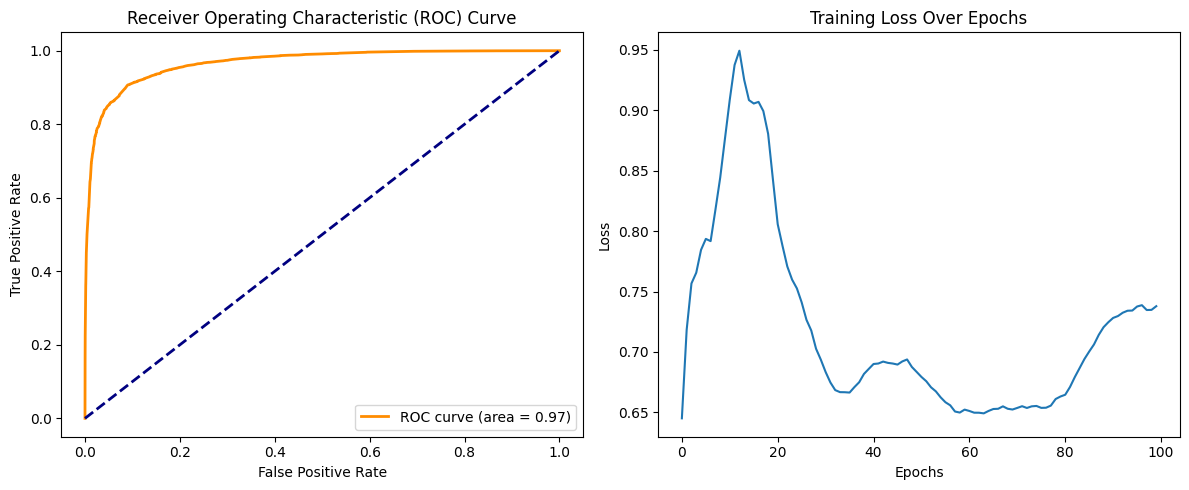

In [98]:

# Plot ROC curve and training loss
plt.figure(figsize=(12, 5))

# Plot ROC curve
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')

# Plot training loss
plt.subplot(1, 2, 2)
plt.plot(training_loss, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')

plt.tight_layout()
plt.show()


In [99]:
# (a) Use your trained neural network to predict the labels of the test dataset and compute the accuracy
test_images_flattened = test_images.reshape(-1, 28 * 28)

# Forward pass on the test dataset
_, _, predictions = feed_forward(test_images_flattened)

# Convert predictions to one-hot encoding
predicted_labels_one_hot = one_hot_encode(np.argmax(predictions, axis=1), num_classes)

# Calculate accuracy
accuracy = np.sum(np.all(predicted_labels_one_hot == test_labels_one_hot, axis=1)) / len(test_labels_one_hot)
print(f"Accuracy on the test dataset: {accuracy * 100:.2f}%")


Accuracy on the test dataset: 92.23%


Number of misclassified samples: 777
Index: 8, True Label: 5, Predicted Label: 6
Index: 63, True Label: 3, Predicted Label: 2
Index: 66, True Label: 6, Predicted Label: 3
Index: 111, True Label: 7, Predicted Label: 1
Index: 124, True Label: 7, Predicted Label: 4
Index: 149, True Label: 2, Predicted Label: 9
Index: 165, True Label: 5, Predicted Label: 8
Index: 182, True Label: 5, Predicted Label: 8
Index: 193, True Label: 9, Predicted Label: 3
Index: 195, True Label: 3, Predicted Label: 8


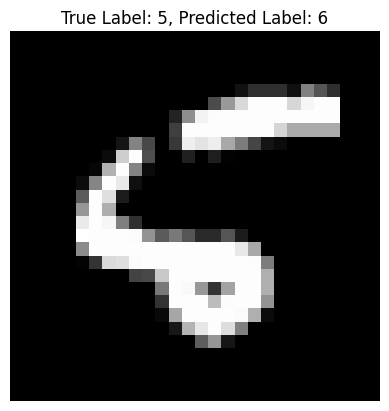

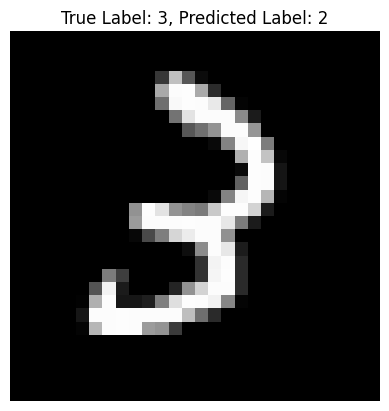

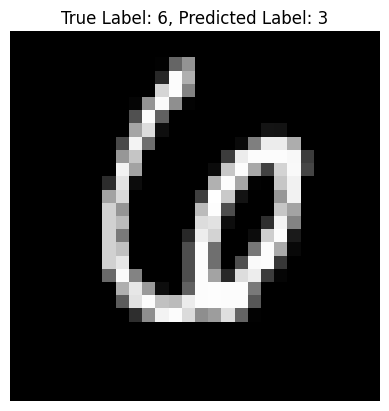

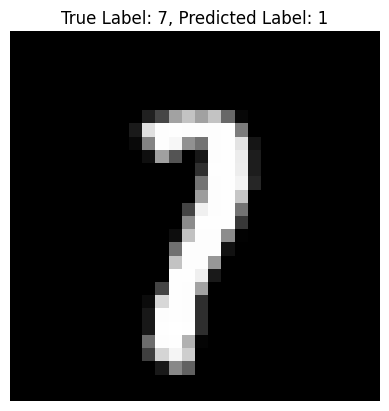

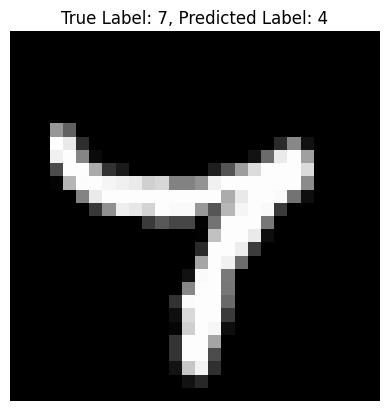

In [100]:
# Find misclassified indices
misclassified_indices = np.where(np.argmax(predicted_labels_one_hot, axis=1) != np.argmax(test_labels_one_hot, axis=1))[0]

# Print the number of misclassified samples
print(f"Number of misclassified samples: {len(misclassified_indices)}")

# Print additional information for debugging
for i in range(min(10, len(misclassified_indices))):
    index = misclassified_indices[i]
    print(f"Index: {index}, True Label: {test_labels[index]}, Predicted Label: {np.argmax(predictions[index])}")

# Plot some of the misclassified images
num_misclassified_to_plot = 5  # Change this as needed
for i in range(min(num_misclassified_to_plot, len(misclassified_indices))):
    index = misclassified_indices[i]
    misclassified_image = test_images[index].reshape(28, 28)

    plt.imshow(misclassified_image, cmap='gray')
    plt.title(f'True Label: {test_labels[index]}, Predicted Label: {np.argmax(predictions[index])}')
    plt.axis('off')
    plt.show()


Training Images Shape: (60000, 28, 28)
Training Labels Shape: (60000,)
Test Images Shape: (10000, 28, 28)
Test Labels Shape: (10000,)


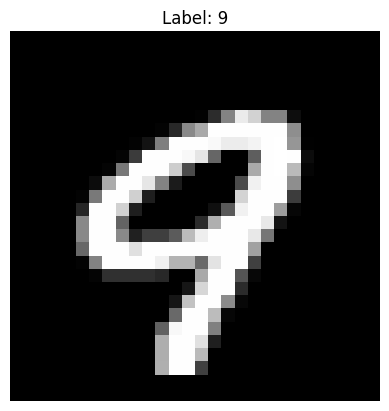

Epoch 0, Loss: 0.3394
Epoch 2, Loss: 0.2913
Epoch 4, Loss: 0.2763
Epoch 6, Loss: 0.2624
Epoch 8, Loss: 0.2511
Epoch 10, Loss: 0.2529
Epoch 12, Loss: 0.2480
Epoch 14, Loss: 0.2401
Epoch 16, Loss: 0.2428
Epoch 18, Loss: 0.2576
Accuracy on the test dataset: 92.25%
Number of misclassified samples: 775
Index: 8, True Label: 5, Predicted Label: 6
Index: 33, True Label: 4, Predicted Label: 0
Index: 63, True Label: 3, Predicted Label: 2
Index: 66, True Label: 6, Predicted Label: 2
Index: 80, True Label: 7, Predicted Label: 9
Index: 92, True Label: 9, Predicted Label: 4
Index: 119, True Label: 2, Predicted Label: 8
Index: 124, True Label: 7, Predicted Label: 4
Index: 144, True Label: 7, Predicted Label: 9
Index: 149, True Label: 2, Predicted Label: 9


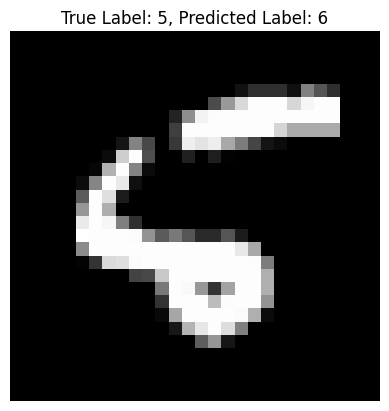

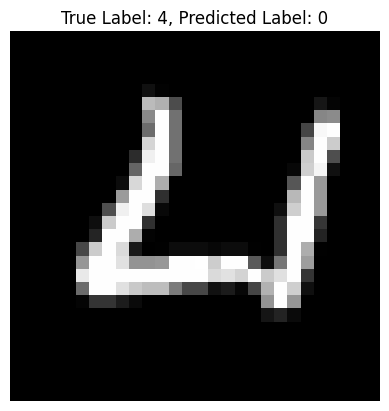

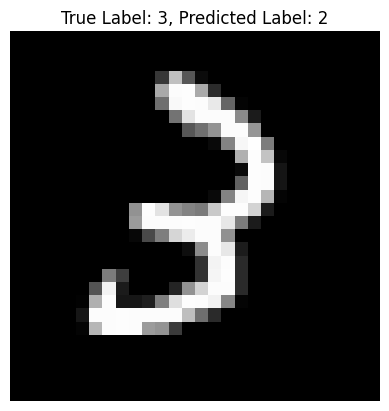

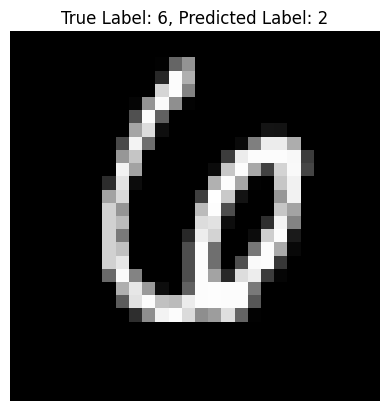

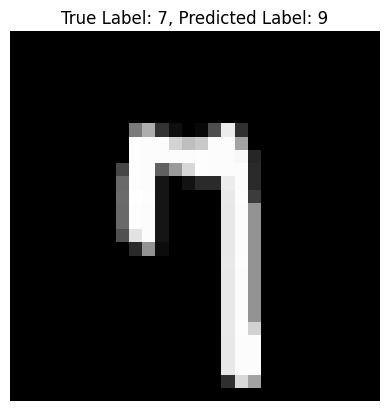

In [101]:
# import gzip
# import struct
# import numpy as np
# import matplotlib.pyplot as plt
# from sklearn.metrics import roc_curve, auc

# def read_idx(filename):
#     with gzip.open(filename, 'rb') as f:
#         zero, data_type, dims = struct.unpack('>HBB', f.read(4))
#         shape = tuple(struct.unpack('>I', f.read(4))[0] for d in range(dims))
#         return np.frombuffer(f.read(), dtype=np.uint8).reshape(shape)

# # File paths for the dataset
# train_images_path = 'data/train-images-idx3-ubyte.gz'
# train_labels_path = 'data/train-labels-idx1-ubyte.gz'
# test_images_path = 'data/t10k-images-idx3-ubyte.gz'
# test_labels_path = 'data/t10k-labels-idx1-ubyte.gz'

# # Read the dataset files
# train_images = read_idx(train_images_path)
# train_labels = read_idx(train_labels_path)
# test_images = read_idx(test_images_path)
# test_labels = read_idx(test_labels_path)

# # Reshape and print the shapes of the datasets
# print("Training Images Shape:", train_images.shape)
# print("Training Labels Shape:", train_labels.shape)
# print("Test Images Shape:", test_images.shape)
# print("Test Labels Shape:", test_labels.shape)

# # Visualize a random image and its label
# import random

# # Get a random index to select a random image and its label
# random_index = random.randint(0, len(train_images))
# random_image = train_images[random_index].reshape(28, 28)
# random_label = train_labels[random_index]

# # Plot the random image using plt.imshow
# plt.imshow(random_image, cmap='gray')
# plt.title(f'Label: {random_label}')
# plt.axis('off')  # Turn off axis
# plt.show()

# # Normalize the pixel values of the images to be between 0 and 1
# train_images_normalized = train_images / 255.0
# test_images_normalized = test_images / 255.0

# # Flatten the images
# train_images_flattened = train_images_normalized.reshape(-1, 28 * 28)
# test_images_flattened = test_images_normalized.reshape(-1, 28 * 28)

# # Convert labels to one-hot encoding
# def one_hot_encode(labels, num_classes):
#     num_labels = len(labels)
#     one_hot_encoded = np.zeros((num_labels, num_classes))
#     one_hot_encoded[np.arange(num_labels), labels] = 1
#     return one_hot_encoded

# num_classes = 10
# train_labels_one_hot = one_hot_encode(train_labels, num_classes)
# test_labels_one_hot = one_hot_encode(test_labels, num_classes)

# # Network Initialization
# np.random.seed(695)

# input_size = 784
# hidden_size1 = 256
# hidden_size2 = 128
# output_size = 10

# # Initialize weights and biases for the neural network
# weights_input_hidden1 = np.random.uniform(-0.1, 0.1, size=(input_size, hidden_size1))
# biases_hidden1 = np.zeros(hidden_size1)

# weights_hidden1_hidden2 = np.random.uniform(-0.1, 0.1, size=(hidden_size1, hidden_size2))
# biases_hidden2 = np.zeros(hidden_size2)

# weights_hidden2_output = np.random.uniform(-0.1, 0.1, size=(hidden_size2, output_size))
# biases_output = np.zeros(output_size)

# # Feed Forward
# def feed_forward(x):
#     hidden1_input = np.dot(x, weights_input_hidden1) + biases_hidden1
#     hidden1_output = sigmoid(hidden1_input)

#     hidden2_input = np.dot(hidden1_output, weights_hidden1_hidden2) + biases_hidden2
#     hidden2_output = sigmoid(hidden2_input)

#     output_layer_input = np.dot(hidden2_output, weights_hidden2_output) + biases_output
#     output = softmax(output_layer_input)

#     return hidden1_output, hidden2_output, output

# # Categorical Crossentropy Loss
# def categorical_crossentropy(y_true, y_pred):
#     n_samples = y_true.shape[0]
#     y_pred_clipped = np.clip(y_pred, 1e-12, 1 - 1e-12)
#     return -np.sum(y_true * np.log(y_pred_clipped)) / n_samples

# # Gradient Computation
# def compute_gradients(x, hidden1_output, hidden2_output, output, y_true):
#     x_flattened = x.reshape(-1, 28 * 28)

#     grad_output = output - y_true
#     weights_gradients_hidden2_output = np.dot(hidden2_output.T, grad_output)
#     biases_gradients_output = np.sum(grad_output, axis=0)

#     grad_hidden2 = np.dot(grad_output, weights_hidden2_output.T) * sigmoid_derivative(hidden2_output)
#     weights_gradients_hidden1_hidden2 = np.dot(hidden1_output.T, grad_hidden2)
#     biases_gradients_hidden2 = np.sum(grad_hidden2, axis=0)

#     grad_hidden1 = np.dot(grad_hidden2, weights_hidden1_hidden2.T) * sigmoid_derivative(hidden1_output)
#     weights_gradients_input_hidden1 = np.dot(x_flattened.T, grad_hidden1)
#     biases_gradients_hidden1 = np.sum(grad_hidden1, axis=0)

#     return {
#         'weights_input_hidden1': weights_gradients_input_hidden1,
#         'biases_hidden1': biases_gradients_hidden1,
#         'weights_hidden1_hidden2': weights_gradients_hidden1_hidden2,
#         'biases_hidden2': biases_gradients_hidden2,
#         'weights_hidden2_output': weights_gradients_hidden2_output,
#         'biases_output': biases_gradients_output,
#     }

# # Hyperparameters
# learning_rate = 0.01
# epochs = 20
# batch_size = 64

# # Training Loop
# for epoch in range(epochs):
#     for i in range(0, len(train_images_flattened), batch_size):
#         x_batch = train_images_flattened[i:i + batch_size]
#         y_batch = train_labels_one_hot[i:i + batch_size]

#         # Forward pass
#         hidden1_output, hidden2_output, output = feed_forward(x_batch)

#         # Backward pass
#         gradients = compute_gradients(x_batch, hidden1_output, hidden2_output, output, y_batch)

#         # Update weights and biases
#         weights_input_hidden1 -= learning_rate * gradients['weights_input_hidden1']
#         biases_hidden1 -= learning_rate * gradients['biases_hidden1']

#         weights_hidden1_hidden2 -= learning_rate * gradients['weights_hidden1_hidden2']
#         biases_hidden2 -= learning_rate * gradients['biases_hidden2']

#         weights_hidden2_output -= learning_rate * gradients['weights_hidden2_output']
#         biases_output -= learning_rate * gradients['biases_output']

#     # Print the loss for every 2 epochs
#     if epoch % 2 == 0:
#         _, _, predictions = feed_forward(train_images_flattened)
#         loss = categorical_crossentropy(train_labels_one_hot, predictions)
#         print(f'Epoch {epoch}, Loss: {loss:.4f}')

# # Test the trained model
# _, _, predictions = feed_forward(test_images_flattened)

# # Calculate accuracy
# accuracy = np.sum(np.argmax(predictions, axis=1) == test_labels) / len(test_labels)
# print(f"Accuracy on the test dataset: {accuracy * 100:.2f}%")

# # Find misclassified indices
# misclassified_indices = np.where(np.argmax(predictions, axis=1) != test_labels)[0]

# # Print the number of misclassified samples
# print(f"Number of misclassified samples: {len(misclassified_indices)}")

# # Print additional information for debugging
# for i in range(min(10, len(misclassified_indices))):
#     index = misclassified_indices[i]
#     print(f"Index: {index}, True Label: {test_labels[index]}, Predicted Label: {np.argmax(predictions[index])}")

# # Plot some of the misclassified images
# num_misclassified_to_plot = 5  # Change this as needed
# for i in range(min(num_misclassified_to_plot, len(misclassified_indices))):
#     index = misclassified_indices[i]
#     misclassified_image = test_images[index].reshape(28, 28)

#     plt.imshow(misclassified_image, cmap='gray')
#     plt.title(f'True Label: {test_labels[index]}, Predicted Label: {np.argmax(predictions[index])}')
#     plt.axis('off')
#     plt.show()


In [ ]:
# import gzip
# import struct
# import numpy as np

# def read_idx(filename):
#     with gzip.open(filename, 'rb') as f:
#         zero, data_type, dims = struct.unpack('>HBB', f.read(4))
#         shape = tuple(struct.unpack('>I', f.read(4))[0] for d in range(dims))
#         return np.frombuffer(f.read(), dtype=np.uint8).reshape(shape)



# # File paths for the dataset
# train_images_path = 'data/train-images-idx3-ubyte.gz'
# train_labels_path = 'data/train-labels-idx1-ubyte.gz'
# test_images_path = 'data/t10k-images-idx3-ubyte.gz'
# test_labels_path = 'data/t10k-labels-idx1-ubyte.gz'

# # Read the dataset files
# train_images = read_idx(train_images_path)
# train_labels = read_idx(train_labels_path)
# test_images = read_idx(test_images_path)
# test_labels = read_idx(test_labels_path)

# # Reshape and print the shapes of the datasets
# print("Training Images Shape:", train_images.shape)
# print("Training Labels Shape:", train_labels.shape)
# print("Test Images Shape:", test_images.shape)
# print("Test Labels Shape:", test_labels.shape)


# import matplotlib.pyplot as plt
# import random

# # Get a random index to select a random image and its label
# random_index = random.randint(0, len(train_images))

# # Select the image and its label
# random_image = train_images[random_index]
# random_label = train_labels[random_index]

# # Reshape the image into a 28x28 format (assuming it's the MNIST image size)
# random_image = random_image.reshape(28, 28)

# # Plot the image using plt.imshow
# plt.imshow(random_image, cmap='gray')
# plt.title(f'Label: {random_label}')
# plt.axis('off')  # Turn off axis
# plt.show()

# # Normalize the pixel values of images to be between 0 and 1
# train_images_normalized = train_images / 255.0
# # Convert labels to one-hot encoding
# def one_hot_encode(labels, num_classes):
#     num_labels = len(labels)
#     index_offset = np.arange(num_labels) * num_classes
#     one_hot_encoded = np.zeros((num_labels, num_classes))
#     one_hot_encoded.flat[index_offset + labels.ravel()] = 1
#     return one_hot_encoded

# num_classes = 10  # As there are 10 classes (0 to 9 for digits)
# train_labels_one_hot = one_hot_encode(train_labels, num_classes)
# def sigmoid(x):
#     clipped_x = np.clip(x, -500, 500)  # Adjust the clipping range as needed
#     return 1 / (1 + np.exp(-clipped_x))

# def sigmoid_derivative(x):
#     return sigmoid(x) * (1 - sigmoid(x))

# def softmax(x):
#     e_x = np.exp(x - np.max(x, axis=-1, keepdims=True))  # for numerical stability
#     return e_x / e_x.sum(axis=-1, keepdims=True)


# np.random.seed(695)  # Setting the seed for reproducibility

# input_size = 784
# hidden_size1 = 128
# hidden_size2 = 64
# output_size = 10

# # Initialize weights and biases for the neural network
# weights_input_hidden1 = np.random.uniform(-0.1, 0.1, size=(input_size, hidden_size1))
# biases_hidden1 = np.zeros(hidden_size1)

# weights_hidden1_hidden2 = np.random.uniform(-0.1, 0.1, size=(hidden_size1, hidden_size2))
# biases_hidden2 = np.zeros(hidden_size2)

# weights_hidden2_output = np.random.uniform(-0.1, 0.1, size=(hidden_size2, output_size))
# biases_output = np.zeros(output_size)

# def feed_forward(x):
#     hidden1_input = np.dot(x, weights_input_hidden1) + biases_hidden1
#     hidden1_output = sigmoid(hidden1_input)

#     hidden2_input = np.dot(hidden1_output, weights_hidden1_hidden2) + biases_hidden2
#     hidden2_output = sigmoid(hidden2_input)

#     output_layer_input = np.dot(hidden2_output, weights_hidden2_output) + biases_output
#     output = softmax(output_layer_input)

#     return hidden1_output, hidden2_output, output


# def categorical_crossentropy(y_true, y_pred):
#     n_samples = y_true.shape[0]
#     y_pred_clipped = np.clip(y_pred, 1e-12, 1 - 1e-12)
#     return -np.sum(y_true * np.log(y_pred_clipped)) / n_samples


# def compute_gradients(x, hidden1_output, hidden2_output, output, y_true):
#     # Flatten the input
#     x_flattened = x.reshape(-1, 28 * 28)

#     # Calculations for the output layer gradients
#     grad_output = output - y_true
#     weights_gradients_hidden2_output = np.dot(hidden2_output.T, grad_output)
#     biases_gradients_output = np.sum(grad_output, axis=0)

#     # Calculations for hidden layer 2 gradients
#     grad_hidden2 = np.dot(grad_output, weights_hidden2_output.T) * sigmoid_derivative(hidden2_output)
#     weights_gradients_hidden1_hidden2 = np.dot(hidden1_output.T, grad_hidden2)
#     biases_gradients_hidden2 = np.sum(grad_hidden2, axis=0)

#     # Calculations for hidden layer 1 gradients
#     grad_hidden1 = np.dot(grad_hidden2, weights_hidden1_hidden2.T) * sigmoid_derivative(hidden1_output)
#     weights_gradients_input_hidden1 = np.dot(x_flattened.T, grad_hidden1)
#     biases_gradients_hidden1 = np.sum(grad_hidden1, axis=0)

#     return weights_gradients_hidden2_output, biases_gradients_output, weights_gradients_hidden1_hidden2, biases_gradients_hidden2, weights_gradients_input_hidden1, biases_gradients_hidden1

# batch_size = 128
# epochs = 100
# learning_rate = 0.01

# # Training loop
# for epoch in range(epochs):
#     for i in range(0, len(train_images), batch_size):
#         batch_images = train_images[i:i + batch_size]
#         batch_labels = train_labels_one_hot[i:i + batch_size]

#         # Handle the last incomplete batch
#         if len(batch_images) < batch_size:
#             # Adjust the gradient calculations for the last batch
#             diff = batch_size - len(batch_images)
#             batch_images = np.concatenate((batch_images, train_images[:diff]))
#             batch_labels = np.concatenate((batch_labels, train_labels_one_hot[:diff]))

#         batch_images_flattened = batch_images.reshape(-1, 28 * 28)  # Flatten each image to a 1D array
#         hidden1_output, hidden2_output, output = feed_forward(batch_images_flattened)
#         gradients = compute_gradients(batch_images, hidden1_output, hidden2_output, output, batch_labels)

        
#         # Update weights and biases using gradients
#         weights_hidden2_output -= learning_rate * gradients[0]
#         biases_output -= learning_rate * gradients[1]
#         weights_hidden1_hidden2 -= learning_rate * gradients[2]
#         biases_hidden2 -= learning_rate * gradients[3]
#         weights_input_hidden1 -= learning_rate * gradients[4]
#         biases_hidden1 -= learning_rate * gradients[5]
    

# print("Done")



In [ ]:
# # (a) Use your trained neural network to predict the labels of the test dataset and compute the accuracy
# test_images_flattened = test_images.reshape(-1, 28 * 28)

# # Forward pass on the test dataset
# _, _, predictions = feed_forward(test_images_flattened)

# # Convert labels to one-hot encoding for the test dataset
# test_labels_one_hot = one_hot_encode(test_labels, num_classes)

# # Convert predictions to one-hot encoding
# predicted_labels_one_hot = one_hot_encode(np.argmax(predictions, axis=1), num_classes)

# # Calculate accuracy
# accuracy = np.sum(np.all(predicted_labels_one_hot == test_labels_one_hot, axis=1)) / len(test_labels_one_hot)
# print(f"Accuracy on the test dataset: {accuracy * 100:.2f}%")



In [ ]:

# # (b) Plot some of the misclassified images with their predicted and true labels
# # Find misclassified indices
# misclassified_indices = np.where(np.all(predicted_labels_one_hot != test_labels_one_hot, axis=1))[0]

# # Plot some of the misclassified images
# num_misclassified_to_plot = 5  # Change this as needed
# for i in range(min(num_misclassified_to_plot, len(misclassified_indices))):
#     index = misclassified_indices[i]

#     # Get the misclassified image and its true label
#     misclassified_image = test_images[index].reshape(28, 28)
#     true_label = test_labels[index]

#     # Get the predicted label
#     predicted_label = np.argmax(predictions[index])

#     # Plot the misclassified image
#     plt.imshow(misclassified_image, cmap='gray')
#     plt.title(f'True Label: {true_label}, Predicted Label: {predicted_label}')
#     plt.axis('off')
#     plt.show()



In [ ]:
# import gzip
# import struct
# import numpy as np
# import matplotlib.pyplot as plt
# from sklearn.metrics import roc_curve, auc

# def read_idx(filename):
#     with gzip.open(filename, 'rb') as f:
#         zero, data_type, dims = struct.unpack('>HBB', f.read(4))
#         shape = tuple(struct.unpack('>I', f.read(4))[0] for d in range(dims))
#         return np.frombuffer(f.read(), dtype=np.uint8).reshape(shape)

# # File paths for the dataset
# train_images_path = 'data/train-images-idx3-ubyte.gz'
# train_labels_path = 'data/train-labels-idx1-ubyte.gz'
# test_images_path = 'data/t10k-images-idx3-ubyte.gz'
# test_labels_path = 'data/t10k-labels-idx1-ubyte.gz'

# # Read the dataset files
# train_images = read_idx(train_images_path)
# train_labels = read_idx(train_labels_path)
# test_images = read_idx(test_images_path)
# test_labels = read_idx(test_labels_path)

# # Reshape and print the shapes of the datasets
# print("Training Images Shape:", train_images.shape)
# print("Training Labels Shape:", train_labels.shape)
# print("Test Images Shape:", test_images.shape)
# print("Test Labels Shape:", test_labels.shape)

# # Normalize the pixel values of the images to be between 0 and 1
# train_images_normalized = train_images / 255.0
# test_images_normalized = test_images / 255.0

# # Flatten the images
# train_images_flattened = train_images_normalized.reshape(-1, 28 * 28)
# test_images_flattened = test_images_normalized.reshape(-1, 28 * 28)

# # Convert labels to one-hot encoding
# def one_hot_encode(labels, num_classes):
#     num_labels = len(labels)
#     one_hot_encoded = np.zeros((num_labels, num_classes))
#     one_hot_encoded[np.arange(num_labels), labels] = 1
#     return one_hot_encoded

# num_classes = 10
# train_labels_one_hot = one_hot_encode(train_labels, num_classes)
# test_labels_one_hot = one_hot_encode(test_labels, num_classes)

# # Network Initialization
# np.random.seed(695)

# input_size = 784
# hidden_size1 = 256  # Increased hidden layer size
# hidden_size2 = 128   # Increased hidden layer size
# output_size = 10

# # Initialize weights and biases for the neural network
# weights_input_hidden1 = np.random.uniform(-0.1, 0.1, size=(input_size, hidden_size1))
# biases_hidden1 = np.zeros(hidden_size1)

# weights_hidden1_hidden2 = np.random.uniform(-0.1, 0.1, size=(hidden_size1, hidden_size2))
# biases_hidden2 = np.zeros(hidden_size2)

# weights_hidden2_output = np.random.uniform(-0.1, 0.1, size=(hidden_size2, output_size))
# biases_output = np.zeros(output_size)

# # Feed Forward
# def feed_forward(x):
#     hidden1_input = np.dot(x, weights_input_hidden1) + biases_hidden1
#     hidden1_output = sigmoid(hidden1_input)

#     hidden2_input = np.dot(hidden1_output, weights_hidden1_hidden2) + biases_hidden2
#     hidden2_output = sigmoid(hidden2_input)

#     output_layer_input = np.dot(hidden2_output, weights_hidden2_output) + biases_output
#     output = softmax(output_layer_input)

#     return hidden1_output, hidden2_output, output

# # Categorical Crossentropy Loss
# def categorical_crossentropy(y_true, y_pred):
#     n_samples = y_true.shape[0]
#     y_pred_clipped = np.clip(y_pred, 1e-12, 1 - 1e-12)
#     return -np.sum(y_true * np.log(y_pred_clipped)) / n_samples

# # Gradient Computation
# def compute_gradients(x, hidden1_output, hidden2_output, output, y_true):
#     x_flattened = x.reshape(-1, 28 * 28)

#     grad_output = output - y_true
#     weights_gradients_hidden2_output = np.dot(hidden2_output.T, grad_output)
#     biases_gradients_output = np.sum(grad_output, axis=0)

#     grad_hidden2 = np.dot(grad_output, weights_hidden2_output.T) * sigmoid_derivative(hidden2_output)
#     weights_gradients_hidden1_hidden2 = np.dot(hidden1_output.T, grad_hidden2)
#     biases_gradients_hidden2 = np.sum(grad_hidden2, axis=0)

#     grad_hidden1 = np.dot(grad_hidden2, weights_hidden1_hidden2.T) * sigmoid_derivative(hidden1_output)
#     weights_gradients_input_hidden1 = np.dot(x_flattened.T, grad_hidden1)
#     biases_gradients_hidden1 = np.sum(grad_hidden1, axis=0)

#     return weights_gradients_hidden2_output, biases_gradients_output, weights_gradients_hidden1_hidden2, biases_gradients_hidden2, weights_gradients_input_hidden1, biases_gradients_hidden1

# # Training Loop
# batch_size = 128
# epochs = 100
# learning_rate = 0.01
# training_loss = []

# for epoch in range(epochs):
#     total_loss = 0
#     for i in range(0, len(train_images), batch_size):
#         batch_images = train_images_normalized[i:i + batch_size]
#         batch_labels = train_labels_one_hot[i:i + batch_size]

#         if len(batch_images) < batch_size:
#             diff = batch_size - len(batch_images)
#             batch_images = np.concatenate((batch_images, train_images_normalized[:diff]))
#             batch_labels = np.concatenate((batch_labels, train_labels_one_hot[:diff]))

#         batch_images_flattened = batch_images.reshape(-1, 28 * 28)
#         hidden1_output, hidden2_output, output = feed_forward(batch_images_flattened)
#         gradients = compute_gradients(batch_images, hidden1_output, hidden2_output, output, batch_labels)

#         # Update weights and biases
#         weights_hidden2_output -= learning_rate * gradients[0]
#         biases_output -= learning_rate * gradients[1]
#         weights_hidden1_hidden2 -= learning_rate * gradients[2]
#         biases_hidden2 -= learning_rate * gradients[3]
#         weights_input_hidden1 -= learning_rate * gradients[4]
#         biases_hidden1 -= learning_rate * gradients[5]

#         loss = categorical_crossentropy(output, batch_labels)
#         total_loss += loss

#     average_loss = total_loss / (len(train_images) / batch_size)
#     training_loss.append(average_loss)

# # Plot Training Loss
# plt.plot(training_loss, label='Training Loss')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.title('Training Loss Over Epochs')
# plt.show()

# # Evaluate on Test Set
# test_images_flattened = test_images_normalized.reshape(-1, 28 * 28)
# _, _, predictions = feed_forward(test_images_flattened)

# # Convert predictions to one-hot encoding for the test dataset
# predicted_labels_one_hot = one_hot_encode(np.argmax(predictions, axis=1), num_classes)

# # Calculate accuracy
# accuracy = np.sum(np.all(predicted_labels_one_hot == test_labels_one_hot, axis=1))

